In [1]:
!pip install newsapi-python
!pip install openpyxl
!pip install yahoo_fin
!pip install nltk
!pip install xlrd

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import requests
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
from newsapi import NewsApiClient
newsapi = NewsApiClient(api_key='36eaec33572c4c06953a924842397a97')


In [83]:
every_headline = newsapi.get_everything(q='asx',
                                         sources="abc-news-au",
                                         from_param = "2021-03-20",
                                         to = "2021-03-22",
                                         sort_by="relevancy",
                                         language='en')
print("Done: {} results found".format(every_headline["totalResults"]))

Done: 5 results found


In [10]:
# Map ASX companies to a list of tuples [(company, code),...]
asx_mapping = pd.read_excel("asx_code_to_company.xlsx", engine='openpyxl')
asx_mapping.Company = asx_mapping.Company.str.replace(" ltd", "", case = False)
asx_companies = list(zip(asx_mapping.Company.str.lower().values,asx_mapping.Code.values))
asx_companies[:10]

[('commonwealth bank of australia', 'CBA'),
 ('bhp group', 'BHP'),
 ('csl', 'CSL'),
 ('westpac banking corporation', 'WBC'),
 ('national australia bank', 'NAB'),
 ('australia and new zealand banking group', 'ANZ'),
 ('fortescue metals group', 'FMG'),
 ('wesfarmers', 'WES'),
 ('macquarie group', 'MQG'),
 ('woolworths group', 'WOW')]

In [11]:
# Extract only content from "n" urls from the news api call (i.e. get rid of unimportant stuff e.g. javascript)
def get_content(n_urls):
    content = []
    
    for n in range(n_urls):
        # Get html of most relevant news article
        r = requests.get(every_headline["articles"][n]["url"])
        text = r.text
        matches = [(m.start(0), m.end(0)) for m in re.finditer("{\"type\":\"text\",\"content\":\"(.*?)\"}", text)]

        for start, end in matches:
            content.append(eval(text[start:end])["content"])
    
    return content

content = get_content(3)

In [14]:
# Create dict of {Company : news about company, ...}
company_news_dict = {}
for company, code in asx_companies:
    r_company = re.compile(fr"\b({str(company)})\b")
    r_code = re.compile(fr"\b({str(code)})\b")
    company_news_dict[str(code)] = [line for line in content if r_company.search(line.lower()) or r_code.search(line)]

# Remove values where a company has no news
keys_to_remove = []
for key in company_news_dict.keys():
    if not company_news_dict[key]:
        keys_to_remove.append(key)

for keys in keys_to_remove:
    company_news_dict.pop(keys)

company_news_dict

{'ANZ': ['Technology and financial stocks were also a drag, including Afterpay (-2.2pc), Bendigo and Adelaide Bank (-1.4pc), AMP (-1.4pc), ANZ (-1.3pc) and Westpac (-0.9pc).'],
 'APT': ['Technology and financial stocks were also a drag, including Afterpay (-2.2pc), Bendigo and Adelaide Bank (-1.4pc), AMP (-1.4pc), ANZ (-1.3pc) and Westpac (-0.9pc).'],
 'SHL': ['Export-reliant healthcare stocks were among the best performers, like Sonic Healthcare (+3.5pc), Clinuvel Pharmaceuticals (+2.5pc), Resmed (+3.3pc) and Healius (+1.7pc).'],
 'STO': ['On the flip side, energy, shopping centres and travel stocks suffered heavy losses, including Unibail Rodamco Westfield (-4.3pc), Flight Centre (-4.2pc), Webjet (-3.4pc) and Corporate Travel Management (-3.9pc), Qantas (-2.3pc) and Santos (-2pc).'],
 'ASX': ['The ASX-listed Crown has confirmed an unsolicited, non-binding offer of $11.85 a share was submitted to the company by Blackstone yesterday.',
  "The report doesn't delve into the other 1,900 c

In [15]:
# Calculate sentiment score for each company and create dict of {code : mean sentiment...}
sid = SentimentIntensityAnalyzer()

def polarity_score(sentence, sid):
    sentiment_dict = sid.polarity_scores(sentence)
    return sentiment_dict["compound"]

asx_sentiment_dict = {}
for code in company_news_dict.keys():
    sentiment = []
    for sentence in company_news_dict[code]:
        sentiment.append(polarity_score(sentence, sid))

    mean_sentiment = sum(sentiment)/len(sentiment)
    asx_sentiment_dict[code] = mean_sentiment

# remove ABC (ABC in this context does not stand for Australian Broadcasting Corporation) as it occurs frequently in ABC articles
asx_sentiment_dict.pop("ABC", None) 
asx_sentiment_dict

{'ANZ': -0.2263,
 'APT': -0.2263,
 'SHL': 0.7717,
 'STO': -0.5859,
 'ASX': -0.07837777777777778,
 'CWN': 0.0,
 'AGL': 0.2553,
 'BEN': -0.2263,
 'AMP': -0.2263,
 'CTD': -0.5859,
 'SUL': 0.5994,
 'HLS': 0.7717,
 'WEB': -0.5859,
 'CUV': 0.7717,
 'FAR': 0.5379250000000001,
 'MWY': 0.0258}

# Backtesting


In [58]:
from yahoo_fin.stock_info import get_data

In [110]:
class backtest():
    
    def __init__(self, asx_sentiment_dict, capital, start_date, end_date):
        self.start_date = start_date
        self.end_date = end_date
        self.codes = [key for key in asx_sentiment_dict.keys() if asx_sentiment_dict[key] > 0]
        self.capital_per_share = capital / len(self.codes)
        self.capital = capital
        self.ticker_data_dict = self.get_ticker_data(asx_sentiment_dict)
        self.delta_time = len(list(self.ticker_data_dict.items())[0][1].index)
        self.init_value = self.get_init_value()
        
    def get_ticker_data(self, asx_sentiment_dict):
        ticker_data_dict = {}
        for code in asx_sentiment_dict.keys():
            if asx_sentiment_dict[code] > 0:
                ticker_data_dict[code] = get_data("{}.AX".format(code), start_date = self.start_date, end_date = self.end_date)
        return ticker_data_dict
    
    def get_init_value(self):
        init_value = {}
        for code in self.codes:
            init_value[code] = self.capital_per_share / self.ticker_data_dict[code].open.iloc[0]
        return init_value
    
    def backtest(self):
        # Find value per day per share at open price
        for code in self.codes:
            self.ticker_data_dict[code]["value"] = self.ticker_data_dict[code].open * self.init_value[code]
        # Find total value of portfolio per day
        total_value_per_day = []
        for i in range(self.delta_time):
            value_per_share = []
            for code in self.codes:
                code_value = self.ticker_data_dict[code]["value"].iloc[i]
                value_per_share.append(code_value)
            total_value_per_day.append(sum(value_per_share))
        # Plot results
        print("Final Value = {:.2f}".format(total_value_per_day[-1]))
        print("Gains/Losses = {:.2f}".format(total_value_per_day[-1] - total_value_per_day[0]))
        sns.set(style='whitegrid', context='talk')
        sns.lineplot(x = list(self.ticker_data_dict.items())[0][1].index.to_list(), y = total_value_per_day)
        sns.despine()
        plt.axhline(y=self.capital, label = "Baseline Capital", color = "red", linestyle = "--")
        plt.xlabel("Date")
        plt.ylabel("Value")
        actual_start_date = pd.to_datetime(self.start_date, format="%m/%d/%Y") - pd.DateOffset(1)
        actual_end_date = pd.to_datetime(self.end_date, format="%m/%d/%Y") - pd.DateOffset(1)
        plt.title("Portfolio Value from {} to {}".format(actual_start_date.strftime("%d/%m/%Y"), actual_end_date.strftime("%d/%m/%Y")))
        plt.xticks(rotation = 45)
        plt.show()

In [130]:
# Backtest strategy
# Dates structure: %m/%d/%Y (will always get data from: start_date & end_date minus 1)
backtester = backtest(asx_sentiment_dict, capital=100000, start_date="03/24/2021", end_date="03/31/2021")

Final Value = 97802.15
Gains/Losses = -2197.85


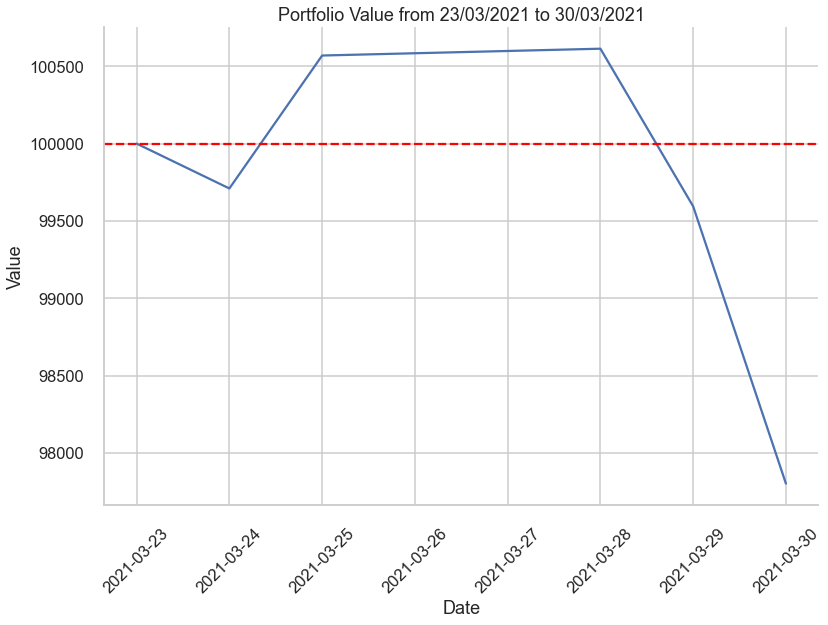

In [131]:
backtester.backtest()